In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

# for type hinting
from typing import List

# for pearson corr coef and p values
from scipy.stats import pearsonr

In [4]:
# for cuda core use but not installing......
#import cupy as cp

In [2]:
# Load data from CSV
df = pd.read_csv('D:\GitHub\MSc-Project-March\SWaT DataSWaT 10 sec.csv')


In [3]:
#df = df.drop(['P101', 'P102', 'P201', 'P202', 'P204', 'P206', 'P401', 'P403', 'P404', 'P502', 'P601', 'P603'], axis=1)

In [4]:
#df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
#df = df.drop(['Timestamp'], axis=1)

In [8]:
df.head()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,date,time
0,0.0,123.97593,1.0,1.0,1.0,251.9226,8.313061,312.79160,0.0,1.0,...,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:00
1,0.0,124.40769,1.0,1.0,1.0,251.9226,8.308960,312.90185,0.0,1.0,...,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:10
2,0.0,123.90527,1.0,1.0,1.0,251.9226,8.310979,312.80442,0.0,1.0,...,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:20
3,0.0,123.90134,1.0,1.0,1.0,251.9226,8.312612,312.91980,0.0,1.0,...,1.0,9.037747,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:30
4,0.0,124.85909,1.0,1.0,1.0,251.9226,8.308191,313.00950,0.0,1.0,...,1.0,9.068188,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:40


See range of values in each column so allow filtering of unchanging values before correlation matrix.

In [9]:
# Get columns
#column_names = df.columns
#rint(column_names)

In [10]:
def drop_static_columns(df: pd.DataFrame) -> (pd.DataFrame, List[str]):
    """
    Find columns in the DataFrame where all values are the same (static columns).

    Parameters:
        df (DataFrame): All values from SWaT .

    Returns:
        df (DataFrame): Columns from SWaT which have more than 1 value.

    Example:
        df = pd.DataFrame({'LIT101': [1.111, 2.222, 3.333], 'P101': [1, 1, 0], 'P102': [1, 1, 1]})
        static_cols = get_static_columns(df, ['A', 'B', 'C'])
        # static_cols will be ['P102'] since all values are 1.
    """
    column_names = df.columns
    static_columns = []
    for column in column_names:
        if df[column].min() == df[column].max():
            static_columns.append(column)

    df_cleaned = df.drop(columns= static_columns)
    return df_cleaned, static_columns


In [11]:
df_cleaned, dropped_columns = drop_static_columns(df)
print(dropped_columns)
# drop time and date
df_cleaned = df_cleaned.drop(columns= ['date', 'time'])
print(df_cleaned.columns)

['P102', 'P201', 'P202', 'P204', 'P206', 'P401', 'P403', 'P404', 'P502', 'P601', 'P603']
Index(['FIT101', 'LIT101', 'MV101', 'P101', 'AIT201', 'AIT202', 'AIT203',
       'FIT201', 'MV201', 'P203', 'P205', 'DPIT301', 'FIT301', 'LIT301',
       'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402',
       'FIT401', 'LIT401', 'P402', 'UV401', 'AIT501', 'AIT502', 'AIT503',
       'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P602'],
      dtype='object')


Styler might be worth it for formatting tables

In [13]:
#help(Styler)

In [82]:
# Calculate the correlation matrix
correlation_matrix = df_cleaned.corr().round(decimals= 4)

# DataFrame to store p-values with rows and cols being column names
p_values = pd.DataFrame(index=df_cleaned.columns, columns=df_cleaned.columns)

# Calculate p-values
# for every column
for col1 in df_cleaned.columns:
    # calculate values with everyother column
    for col2 in df_cleaned.columns:
        correlation_coefficient, p_value = pearsonr(df[col1], df[col2])
        # Save values to corresponding location in p_values df, rounded to 4.d.p
        p_values.loc[col1, col2] = round(p_value, 4)

# Apply a color gradient to the correlation matrix and display it
correlation_matrix_styled  = correlation_matrix.style.background_gradient(cmap='coolwarm').format(precision= 2)
p_values_styled  = p_values.style.background_gradient(cmap='coolwarm').format(precision= 2)



In [99]:
# Display correlation matrix and p-values
#print("Correlation Matrix:")
#display(correlation_matrix_styled)
#print("\nP-values:")
#display(p_values_styled)

Use a class to hold knowledge about each component which can be updated throughout pipeline. Can include functions which return top antecendent/ dependent modules etc.

In [84]:
# class to act as knowledge object for each component in the system
class Component:
    def __init__(self, name, list_position, correlation_dict= None, p_value_dict= None):
        self.name = name
        # position in results list
        self.list_position = list_position

        # empty dict for results from EDA for components relationship to all other components
        self.correlation_dict = correlation_dict if correlation_dict is not None else []
        self.p_value_dict = p_value_dict if p_value_dict is not None else []


    def get_correlated_components(self, lower_threshold= 0, upper_threshold= 1):
        """
        Returns correlations, takes optional min threshold argument (default is 1 for all values).

        Parameters:
        - threshold: The minimum correlation value.

        Returns:
        - A dictionary containing component names as keys and correlation values as values.
        """
        correlated_components = {}
        for component, correlation in self.correlation_dict.items():
            if abs(correlation) >= lower_threshold and abs(correlation) <= upper_threshold:
                correlated_components[component] = correlation
        return correlated_components

    def get_correlated_components_p_value(self, lower_threshold= 0, upper_threshold= 0.05):
        """
        Returns correlated components by p-value, takes optional max threshold argument (default is 1 for all values).

        Parameters:
        - threshold: The minimum correlation value.

        Returns:
        - A dictionary containing component names as keys and p values as values.
        """
        correlated_components_p_value = {}
        for component, p_value in self.p_value_dict.items():
            if p_value >= lower_threshold and p_value <= upper_threshold:
                correlated_components_p_value[component] = p_value
        return correlated_components_p_value



In [85]:
# iterate through every column and create object of component class
# dictionary for all components
components = {}
for n, component in enumerate(df_cleaned.columns):
    # print(n, component)
    components[component] = Component(name= component, list_position= n)


In [100]:
specific_component = components['LIT101']
#specific_component.list_position

List of corr and p values

In [87]:
# assign correlation row to apprpriate component
# Iterate through dictionary by name value
for component_name, component_obj in components.items():
    # convert corr coef row to list
    correlation_coefs = list(correlation_matrix.loc[component_name])
    component_obj.correlation_list= correlation_coefs

    p_value_list = list(p_values.loc[component_name])
    component_obj.p_value_list= p_value_list


Dict version

In [88]:
# Assuming components is a dictionary with component names as keys and Component objects as values
for component_name, component_obj in components.items():
    # Convert correlation coefficient row to dictionary with row index and value
    correlation_dict = {col: value for col, value in zip(correlation_matrix.columns, correlation_matrix.loc[component_name])}
    component_obj.correlation_dict = correlation_dict

    # Convert p-value row to dictionary with row index and value
    p_value_dict = {col: value for col, value in zip(p_values.columns, p_values.loc[component_name])}
    #p_value_dict = {index: value for index, value in enumerate(p_values.loc[component_name])}
    component_obj.p_value_dict = p_value_dict

In [89]:
#index_values = correlation_matrix.index.values
#print(index_values)

In [90]:
specific_component = components['LIT101']
#specific_component.correlation_list
#specific_component.correlation_dict

In [108]:
specific_component.get_correlated_components(0.2,1)

{'FIT101': -0.6478,
 'LIT101': 1.0,
 'MV101': -0.6527,
 'P101': -0.6587,
 'AIT202': 0.2195,
 'FIT201': -0.6668,
 'MV201': -0.6591,
 'P203': -0.6671,
 'P205': -0.4893,
 'AIT501': 0.2652}

In [106]:
specific_component.get_correlated_components_p_value(0.0, 0.05)

{'FIT101': 0.0,
 'LIT101': 0.0,
 'MV101': 0.0,
 'P101': 0.0,
 'AIT202': 0.0,
 'AIT203': 0.0,
 'FIT201': 0.0,
 'MV201': 0.0,
 'P203': 0.0,
 'P205': 0.0,
 'DPIT301': 0.0,
 'FIT301': 0.0,
 'LIT301': 0.0,
 'MV301': 0.0,
 'MV302': 0.0,
 'MV303': 0.0,
 'MV304': 0.0037,
 'P301': 0.0,
 'P302': 0.0,
 'AIT401': 0.0,
 'AIT402': 0.0,
 'FIT401': 0.0,
 'LIT401': 0.0,
 'P402': 0.0,
 'UV401': 0.0,
 'AIT501': 0.0,
 'AIT502': 0.0,
 'AIT503': 0.0,
 'AIT504': 0.0,
 'FIT501': 0.0,
 'FIT502': 0.0,
 'FIT503': 0.0,
 'FIT504': 0.0,
 'P501': 0.0,
 'PIT501': 0.0,
 'PIT502': 0.0,
 'PIT503': 0.0,
 'FIT601': 0.0,
 'P602': 0.0}

In [94]:
#filename = 'D:\GitHub\MSc-Project\SWaT DataSWaT 10 sec.csv'

#df.to_csv(filename, index = False)

Get distributions for each variable. Get range, divide into 100 bins then count variables ineach. Visualise in plot

In [95]:
# make new df to hold variable distributions
df_distributions = pd.DataFrame()

Sample df as 10 second mean for all values so df is 10% of original to east manipulation

In [96]:
def plotBinCounts(name, bin_counts, bin_edges):
    '''
    Function to plot the distribution of bin counts.
    Parameters:
    - bin_counts: a pandas Series containing the counts of values in each bin.
    - bin_edges: an array containing the bin edges.
    '''

    # Set the size of the plot
    plt.figure(figsize=(10,6))

    # Plot the bin counts
    bin_counts.plot(kind='bar', logy=True)

    # Set the title and labels
    plt.title(f'Distribution of {name}')
    plt.ylabel('Counts')

    # Calculate total range and step size for approximately 10 divisions
    total_range = bin_edges[-1] - bin_edges[0]
    step_size = total_range / 10

    # Round step size to a whole number (e.g., 10, 20, etc.) that makes sense for your data
    rounded_step_size = round(step_size / 10) * 10

    # Generate custom tick positions and labels
    tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))
    tick_labels = [f"{bin_edges[int(pos)]:.0f}" for pos in tick_positions]

    # Set x-ticks to represent the overall value range of the bins
    plt.xticks(ticks=tick_positions,
               labels=tick_labels,
               rotation=45)  # Rotate labels for better readability

    # Optional: Set x-axis label
    plt.xlabel('Value Range')

    # Show the plot
    plt.show()

# Example usage:
# Assuming bin_counts and bins are obtained from the getDistribution function
# plotBinCounts(bin_counts, bins)


In [97]:
# function to get distribution
def getDistribution(variable_col):
    '''
    Function to get distribution of values in variable column.
    Returns
    '''
    #get variable min and max values and calculate range

    var_range = df[variable_col].max() - df[variable_col].min()

    print(f'Var Range:  {var_range}')

    # divide into 100 bins
    bin_size = var_range/100

    # Create bins edges from min to max with using bin_size'
    bins = np.arange(df[variable_col].min(), df[variable_col].max() + bin_size, bin_size)

    # Use pd.cut to segment and sort the data values into bins
    df_distributions[variable_col + '_bins'] = pd.cut(df[variable_col], bins=bins, include_lowest=True)

    # Count the number of values in each bin
    bin_counts = df_distributions[variable_col + '_bins'].value_counts().sort_index()

    # call sisualisation function
    plotBinCounts(variable_col, bin_counts, bins)

    # return bin_counts, bins

Var Range:  696.22615


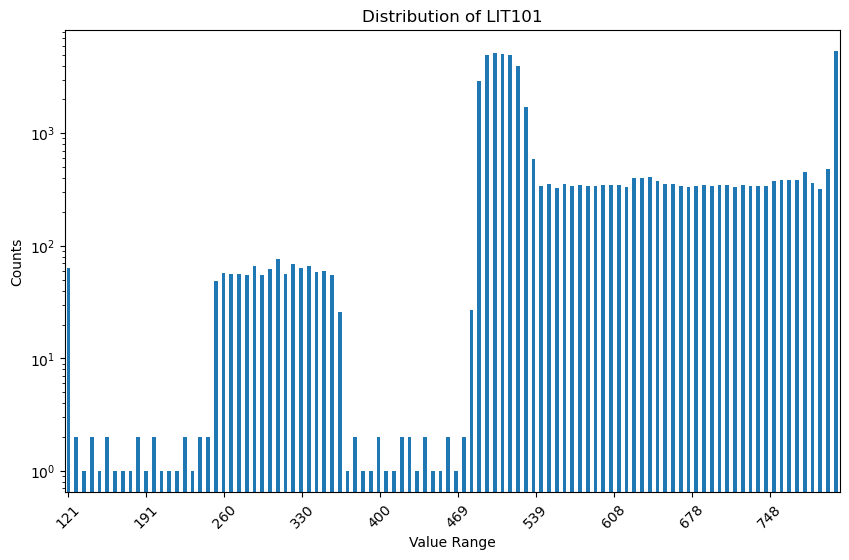

In [98]:
# test with FIT101
#lit101_dist, bins = getDistribution('LIT101')
#plotBinCounts(lit101_dist, bins)

getDistribution('LIT101')

1,FIT-101,Sensor,Flow meter; Measures inflow into raw water tank.
2,LIT-101,Sensor,Level Transmitter; Raw water tank level.
3,MV-101,Actuator,Motorized valve; Controls water flow to the raw water tank.

Var Range:  1.9


C:\Users\laure\AppData\Local\Temp\ipykernel_2536\2836748902.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))


ValueError: Maximum allowed size exceeded

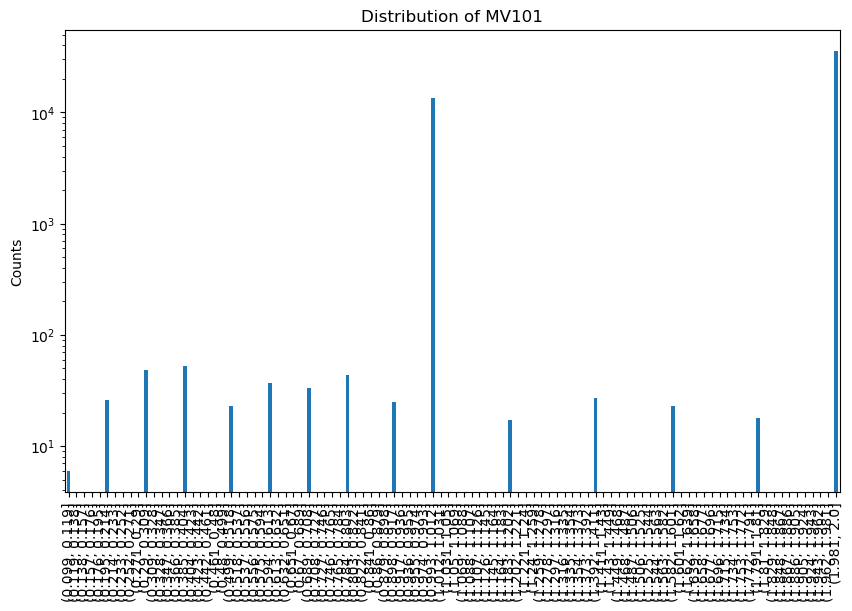

In [105]:
getDistribution('MV101')

Var Range:  2.6828618


C:\Users\laure\AppData\Local\Temp\ipykernel_2536\2836748902.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))


ValueError: Maximum allowed size exceeded

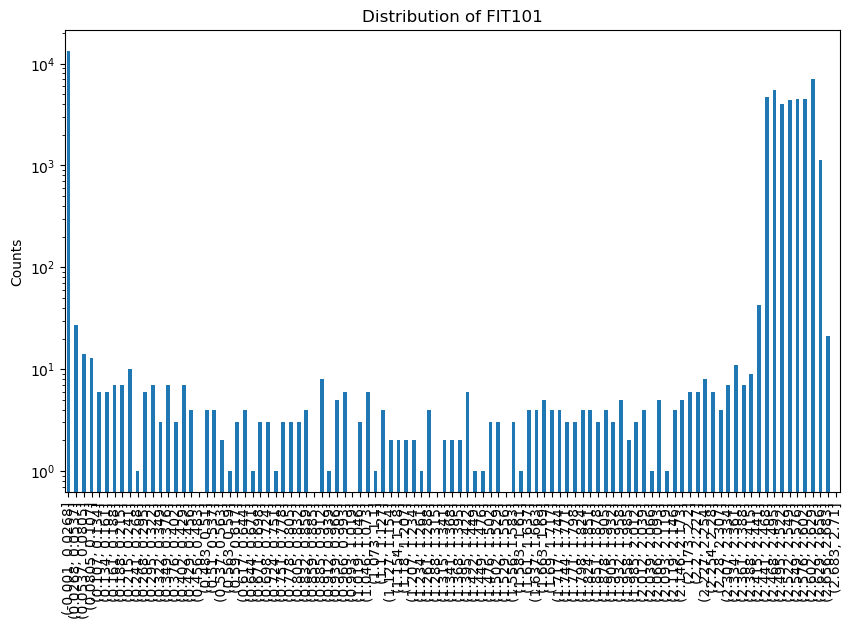

In [106]:
getDistribution('FIT101')

Var Range:  1.0


C:\Users\laure\AppData\Local\Temp\ipykernel_2536\2836748902.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))


ValueError: Maximum allowed size exceeded

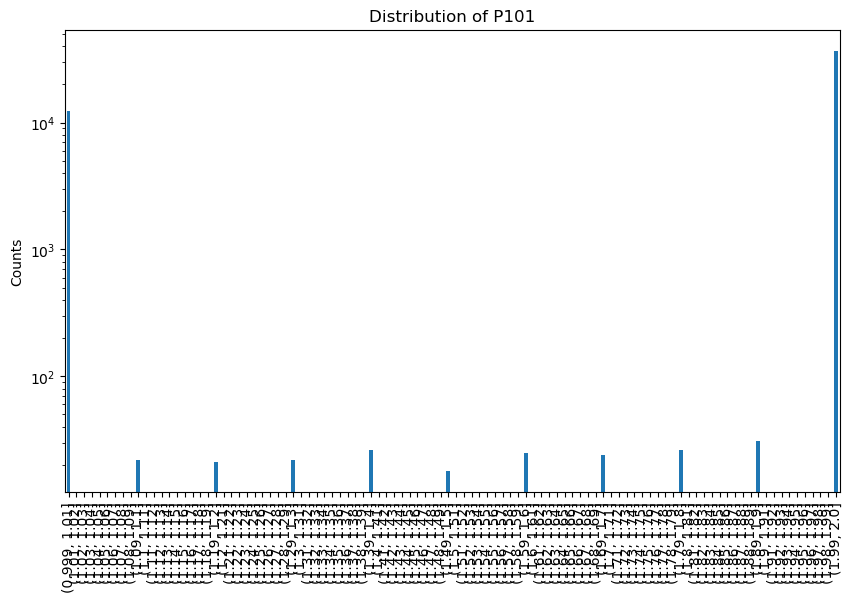

In [107]:
getDistribution('P101')